In [1]:
import pandas as pd
import math
from collections import Counter
from graphviz import Digraph
from IPython.display import Image

# Decision Tree Algorithm

In [2]:
class DecisionNode:
    def __init__(self, attribute):
        self.attribute = attribute
        self.children = {}

    def add_child(self, value, node):
        self.children[value] = node

class LeafNode:
    def __init__(self, classification):
        self.classification = classification

def entropy(examples):
    counts = examples.value_counts(normalize=True)
    return -sum(counts * counts.apply(math.log2))

def information_gain(attribute, examples):
    attribute_values = examples[attribute].unique()
    remainder = 0
    for value in attribute_values:
        exs = examples[examples[attribute] == value]
        remainder += (len(exs) / len(examples)) * entropy(exs["WillWait"])
    return entropy(examples["WillWait"]) - remainder

def plurality_value(examples):
    counts = examples["WillWait"].value_counts()
    return LeafNode(counts.idxmax())

def decision_tree_learning(examples, attributes, parent_examples):
    if len(examples) == 0:
        return plurality_value(parent_examples)
    elif len(examples["WillWait"].unique()) == 1:
        return LeafNode(examples["WillWait"].iloc[0])
    elif len(attributes) == 0:
        return plurality_value(examples)
    else:
        A = max(attributes, key=lambda a: information_gain(a, examples))
        node = DecisionNode(A)
        for value in examples[A].unique():
            exs = examples[examples[A] == value].drop(A, axis=1)
            subtree = decision_tree_learning(exs, attributes - set([A]), examples)
            node.add_child(value, subtree)
        return node

# Load the dataset

In [3]:
# read dataset
df = pd.read_csv("Resturant.csv")

In [4]:
df.head(12)

,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,WillWait
0,1,0,0,1,Some,3,0,1,French,0-10,1
1,1,0,0,1,Full,1,0,0,Thai,30-60,0
2,0,1,0,0,Some,1,0,0,Burger,0-10,1
3,1,0,1,1,Full,1,1,0,Thai,30-Oct,1
4,1,0,1,0,Full,3,0,1,French,>60,0
5,0,1,0,1,Some,2,1,1,Italian,0-10,1
6,0,1,0,0,None,1,1,0,Burger,0-10,0
7,0,0,0,1,Some,2,1,1,Thai,0-10,1
8,0,1,1,0,Full,1,1,0,Burger,>60,0
9,1,1,1,1,Full,3,0,1,Italian,30-Oct,0


In [5]:
X = df.drop("WillWait", axis=1) # Features are all columns except WillWait

In [6]:
# train decision tree
attributes = set(df.columns) - set(["WillWait"])

In [8]:
print(attributes)

{'Price', 'Res', 'Fri', 'Type', 'Est', 'Alt', 'Bar', 'Hun', 'Rain', 'Pat'}


# Implement the Algorithm on dataset

In [10]:
tree = decision_tree_learning(df, attributes, None)

# Print and Display the tree

In [11]:
# print decision tree
def print_tree(node, indent=0):
    if isinstance(node, LeafNode):
        print(" " * indent, "Leaf: ", node.classification)
    else:
        print(" " * indent, "Test: ", node.attribute)
        for value, child in node.children.items():
            print(" " * (indent + 2), value)
            print_tree(child, indent + 4)

print_tree(tree)

 Test:  Pat
   Some
     Leaf:  1
   Full
     Test:  Price
       1
         Test:  Est
           30-60
             Test:  Type
               Thai
                 Leaf:  0
               Burger
                 Leaf:  1
           30-Oct
             Leaf:  1
           >60
             Leaf:  0
       3
         Leaf:  0
   None
     Leaf:  0


In [17]:
# visualize decision tree
def visualize_tree(node, dot):
    if isinstance(node, LeafNode):
        dot.node(str(id(node)), "WillWait = " + str(node.classification))
    else:
        dot.node(str(id(node)), node.attribute)
        for value, child in node.children.items():
            child_node_id = id(child)
            if isinstance(child, LeafNode):
                dot.node(str(child_node_id), "WillWait = " + str(child.classification))
            else:
                dot.node(str(child_node_id), child.attribute)
            #dot.edge(str(id(node)), str(child_node_id), label=value)
            dot.edge(str(id(node)), str(child_node_id), label=str(value))
            #dot.edge(str(id(node)), str(child_node_id), label=value.decode('utf-8'))
            visualize_tree(child, dot)

dot = Digraph()
visualize_tree(tree, dot)
dot.render("tree.gv", format="png")

'tree.gv.png'

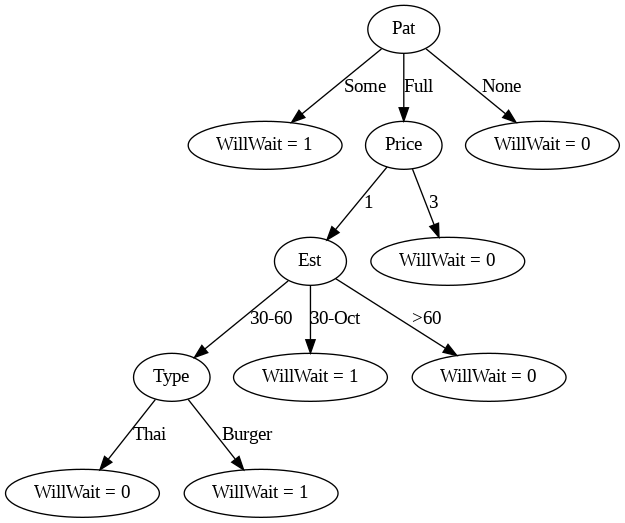

In [18]:
Image(filename='tree.gv.png')